In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
import matplotlib.pyplot as plt
import lightgbm as lgb
import joblib

sys.path.append(os.path.abspath("../"))

import src.nested_cv
import importlib
importlib.reload(src.nested_cv)

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score


from src.nested_cv import RepeatedNestedCV

np.random.seed(42)

In [15]:
# Load dataset
df = pd.read_csv("../data/breast_cancer_final.csv")
df['diagnosis'] = df['diagnosis'].map({'B': 0, 'M': 1})

X = df.drop(columns=["diagnosis"])
y = df["diagnosis"]


In [16]:
estimators = [
    ("LogisticRegression", LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000)),
    ("GaussianNB", GaussianNB()),
    ("LDA", LinearDiscriminantAnalysis()),
    ("SVM", SVC(probability=True)),
    ("RandomForest", RandomForestClassifier()),
    ("LightGBM", LGBMClassifier())
]

param_spaces = {
    "LogisticRegression": {
        "C": [0.1, 1.0],
        "l1_ratio": [0.0, 0.5]
    },
    "GaussianNB": {
        "var_smoothing": [1e-9, 1e-8]
    },
    "LDA": {
        "solver": ["svd", "lsqr", "eigen"],
        "shrinkage": ["auto", None]
    },
    "SVM": {
        "C": [1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale"]
    },
    "RandomForest": {
        "n_estimators": [100],
        "max_depth": [None, 10]
    },
    "LightGBM": {
        "num_leaves": [31],
        "learning_rate": [0.1],
        "n_estimators": [100],
        "max_depth": [-1],
        "reg_alpha": [0.0],
        "reg_lambda": [0.0]
    }
}

In [17]:
cv_runner = RepeatedNestedCV(
    estimators=estimators,
    param_spaces=param_spaces,
    n_repeats=10,           # R
    n_outer_folds=5,        # N
    n_inner_folds=3,        # K
    n_trials=5,             # Optuna trials
    random_state=42
)

cv_runner.fit(X, y)


In [ ]:
# Get all fold-level results
results_df = cv_runner.get_results()
display(results_df.head())

# Summarize results across folds and repeats
summary_df = cv_runner.summarize_results()
display(summary_df)


best_name, best_summary = cv_runner.get_best_estimator(metric="MCC")
print(f"Best model: {best_name}")
display(best_summary)


,estimator,repeat,outer_fold,MCC,AUC,BA,F1,F2,Recall,Precision,PRAUC,NPV,Specificity
0,LogisticRegression,0,0,0.887453,0.997085,0.936224,0.925926,0.905797,0.892857,0.961538,0.995021,0.941176,0.979592
1,GaussianNB,0,0,0.773278,0.982507,0.880102,0.851852,0.833333,0.821429,0.884615,0.971971,0.901961,0.938776
2,LDA,0,0,0.890198,0.997085,0.928571,0.923077,0.882353,0.857143,1.000000,0.995268,0.924528,1.000000
3,SVM,0,0,0.887453,0.994169,0.936224,0.925926,0.905797,0.892857,0.961538,0.990276,0.941176,0.979592
4,RandomForest,0,0,0.859594,0.988703,0.918367,0.905660,0.875912,0.857143,0.960000,0.981752,0.923077,0.979592


,MCC_median,MCC_<lambda_0>,MCC_<lambda_1>,AUC_median,AUC_<lambda_0>,AUC_<lambda_1>,BA_median,BA_<lambda_0>,BA_<lambda_1>,F1_median,...,Precision_<lambda_1>,PRAUC_median,PRAUC_<lambda_0>,PRAUC_<lambda_1>,NPV_median,NPV_<lambda_0>,NPV_<lambda_1>,Specificity_median,Specificity_<lambda_0>,Specificity_<lambda_1>
estimator,,,,,,,,,,,,,,,,,,,,,
GaussianNB,0.884894,0.740427,0.972111,0.987245,0.960969,1.000000,0.935232,0.869690,0.988232,0.924501,...,1.0,0.980231,0.897105,1.000000,0.942308,0.890930,1.0,0.959184,0.897959,1.0
LDA,0.929902,0.812183,0.972111,0.996653,0.970463,1.000000,0.957963,0.882032,0.989954,0.952467,...,1.0,0.994741,0.969778,1.000000,0.960784,0.890909,1.0,1.000000,0.979592,1.0
LightGBM,0.917249,0.807440,1.000000,0.995227,0.970609,1.000000,0.961735,0.886050,1.000000,0.947368,...,1.0,0.991774,0.966598,1.000000,0.970131,0.894621,1.0,0.980000,0.943367,1.0
LogisticRegression,0.944541,0.868772,1.000000,0.997061,0.978420,1.000000,0.971277,0.914732,1.000000,0.962963,...,1.0,0.995121,0.974770,1.000000,0.979592,0.911260,1.0,1.000000,0.943367,1.0
RandomForest,0.888977,0.782011,0.972111,0.994054,0.956432,0.999918,0.943420,0.880995,0.988074,0.927249,...,1.0,0.989617,0.950177,0.999723,0.959184,0.904254,1.0,0.969796,0.938776,1.0
SVM,0.943878,0.864915,1.000000,0.996720,0.973998,1.000000,0.971710,0.925947,1.000000,0.963624,...,1.0,0.994495,0.972744,1.000000,0.979592,0.924528,1.0,0.980000,0.959184,1.0


Best model: LogisticRegression


MCC_median                0.944541
MCC_<lambda_0>            0.868772
MCC_<lambda_1>            1.000000
AUC_median                0.997061
AUC_<lambda_0>            0.978420
AUC_<lambda_1>            1.000000
BA_median                 0.971277
BA_<lambda_0>             0.914732
BA_<lambda_1>             1.000000
F1_median                 0.962963
F1_<lambda_0>             0.906712
F1_<lambda_1>             1.000000
F2_median                 0.962963
F2_<lambda_0>             0.858715
F2_<lambda_1>             1.000000
Recall_median             0.962963
Recall_<lambda_0>         0.829464
Recall_<lambda_1>         1.000000
Precision_median          1.000000
Precision_<lambda_0>      0.906983
Precision_<lambda_1>      1.000000
PRAUC_median              0.995121
PRAUC_<lambda_0>          0.974770
PRAUC_<lambda_1>          1.000000
NPV_median                0.979592
NPV_<lambda_0>            0.911260
NPV_<lambda_1>            1.000000
Specificity_median        1.000000
Specificity_<lambda_

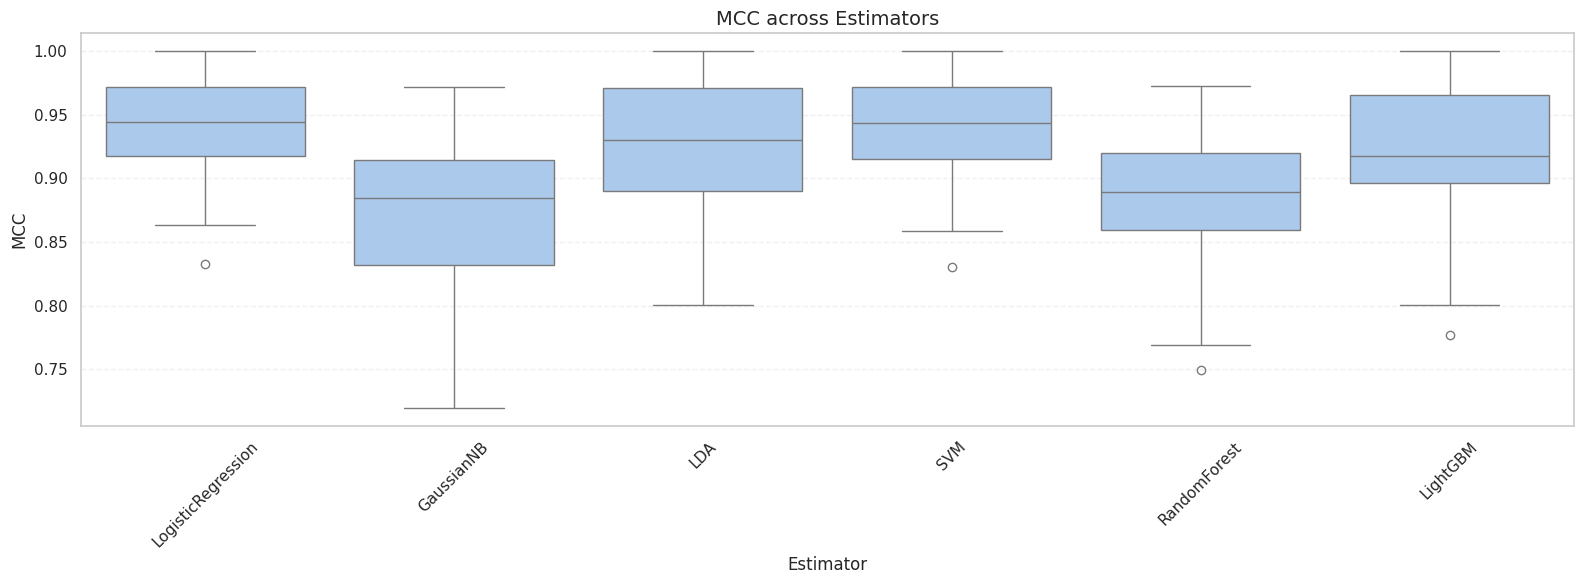

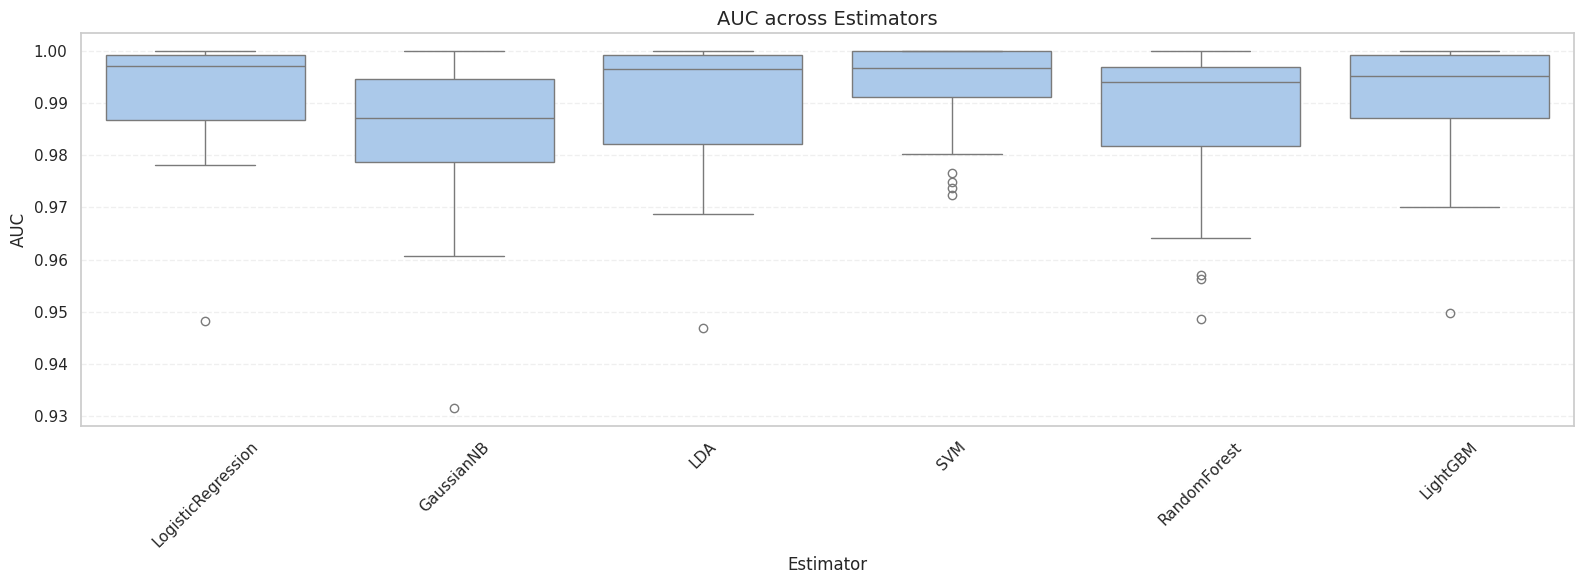

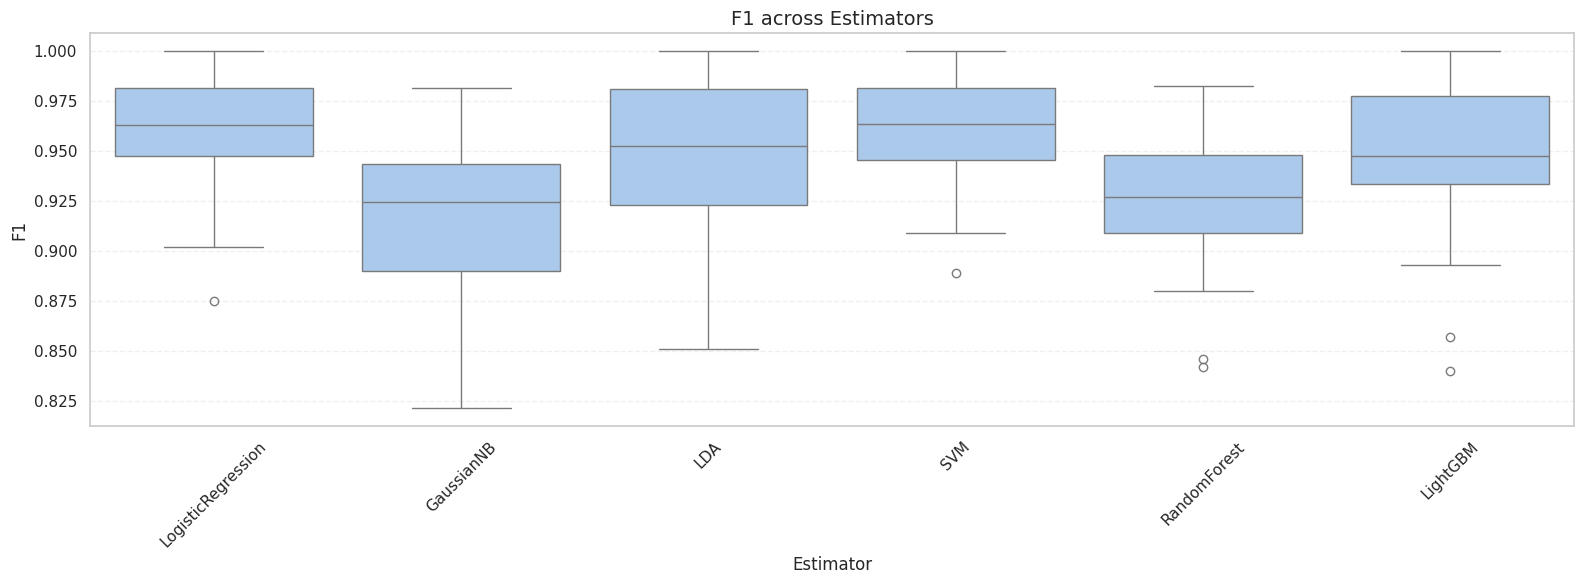

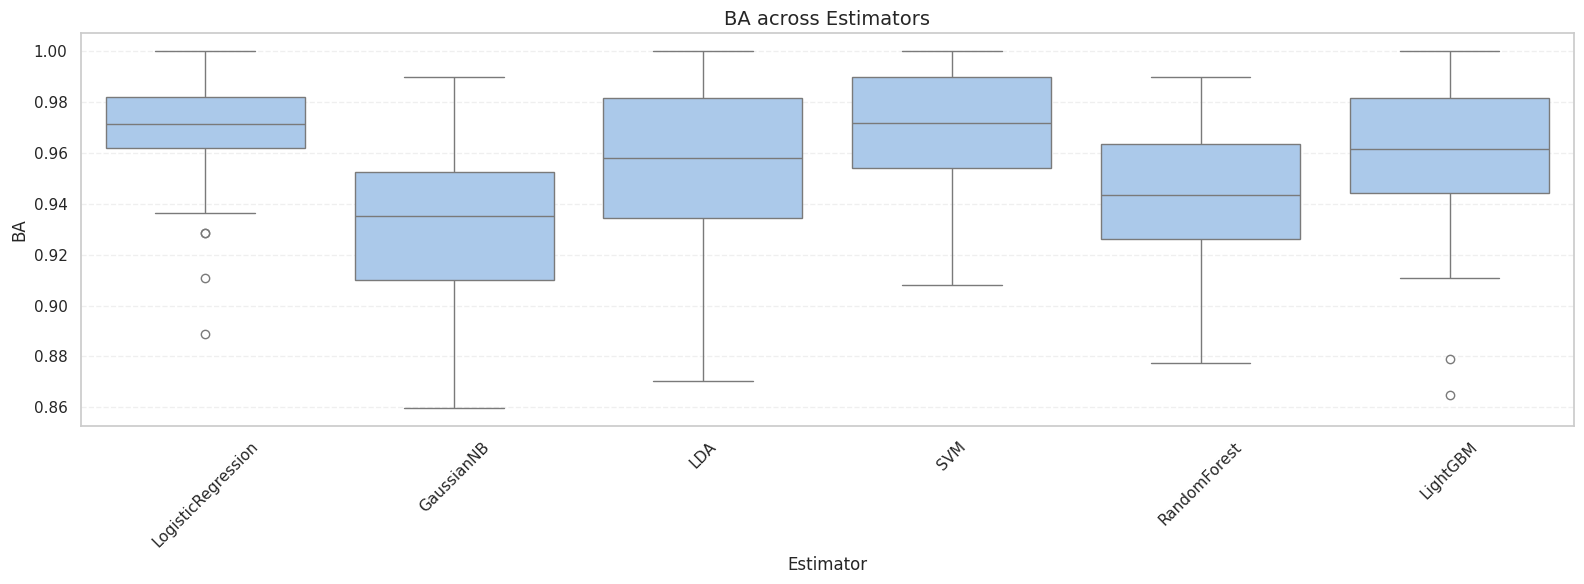

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_box_metrics(results_df, metrics=None, figsize=(16, 6), palette="pastel"):
    """
    Plot boxplots of model performance across folds for selected metrics.

    Parameters:
    - results_df: pd.DataFrame from get_results()
    - metrics: list of metric names to plot (default: all except 'estimator', 'repeat', 'outer_fold')
    - figsize: tuple for plot size
    - palette: seaborn color palette (default: 'pastel')
    """
    if metrics is None:
        metrics = [col for col in results_df.columns if col not in ['estimator', 'repeat', 'outer_fold']]

    sns.set(style="whitegrid", palette=palette)

    for metric in metrics:
        plt.figure(figsize=figsize)
        sns.boxplot(data=results_df, x='estimator', y=metric)
        plt.title(f'{metric} across Estimators', fontsize=14)
        plt.ylabel(metric)
        plt.xlabel('Estimator')
        plt.xticks(rotation=45)
        plt.grid(True, axis='y', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()

results = cv_runner.get_results()
plot_box_metrics(results, metrics=["MCC", "AUC", "F1", "BA"])


### The best model is : **Logistic Regression**

# Task 4 - Step 1

In [23]:
def tune_logistic_regression(X, y, n_trials=20, random_state=42):
    def objective(trial):
        C = trial.suggest_categorical('C', [0.01, 0.1, 1.0, 10.0])
        l1_ratio = trial.suggest_categorical('l1_ratio', [0.0, 0.5, 1.0])  # 0 = L2, 1 = L1, in-between = ElasticNet

        model = LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            max_iter=10000,
            C=C,
            l1_ratio=l1_ratio,
            random_state=random_state
        )

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        aucs = []

        for train_idx, val_idx in cv.split(X, y):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_val)[:, 1]
            aucs.append(roc_auc_score(y_val, y_proba))

        return np.mean(aucs)

    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=random_state))
    study.optimize(objective, n_trials=n_trials)

    print("Best AUC:", study.best_value)
    print("Best hyperparameters:", study.best_params)
    return study.best_params

best_params = tune_logistic_regression(X, y)


Best AUC: 0.9953136810279668
Best hyperparameters: {'C': 1.0, 'l1_ratio': 0.0}


### Step 2

In [30]:
# Load raw data
raw_data = pd.read_csv("../data/breast_cancer.csv")


final_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=10000,
        C=1.0,
        l1_ratio=0.0,
        random_state=42
    ))
])

#Data encoding
raw_data['diagnosis'] = raw_data['diagnosis'].map({'B': 0, 'M': 1})

X = raw_data.drop(columns=["diagnosis", 'id'])
y = raw_data["diagnosis"]

# Fit on full dataset
final_pipeline.fit(X, y)

# Save pipeline
joblib.dump(final_pipeline, "../models/winner.pkl")

print("Final pipeline trained and saved as 'winner.pkl'")

Final pipeline trained and saved as 'winner.pkl'
